In [1]:
import sys

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../RD-systems-and-test-benches/utils")
import model_fsolve as modf
import model_fsolve_v2 as modf2

import scipy.optimize as sco
import scipy.interpolate as sci

import hx_hydraulic as hxhy
import from_excel as fe
import data_plots as dplt

import fluids as fds
from CoolProp.CoolProp import PropsSI

import openpyxl as opxl
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
import os
import plotly.graph_objects as go

import utils.data_processing as dp
import utils.conversion as conv

import copy

from tqdm import tqdm

from plot_config import *

In [2]:
df = pd.DataFrame()

df['Vdot'] = np.array([277, 530, 780, 1010])
df['Q'] = df['Vdot'].apply(lambda x: conv.convert_flow_rate(x, 'L/h', 'm3/s'))

In [3]:
path = r"G:\Drive partagés\Cercle Hard\R&D\Modèles numériques PVT\PVT-PL-model\Inputs"
file_name = "\V4.6_updated_maddalena.xlsx"
hw, par, cond = fe.initialize(path, file_name)

fluid = {'name':'MPG','glycol_rate':0.4}
T_op = 20
p_op = 1

rho_op = PropsSI('D', 'T', conv.to_K(T_op), 'P', p_op*1e5, hxhy.find_fluid(fluid))
mu_op = PropsSI('V', 'T', conv.to_K(T_op), 'P', p_op*1e5, hxhy.find_fluid(fluid))

fe.change_fluid(cond, fluid)
fe.change_temperature(cond, conv.to_K(T_op), fluid)

# tabl, res, PL, residuals = modf.PL_fsolve(par, cond) 

In [4]:
res_dict = {}
PL_res = []

for Vdot in tqdm(df['Vdot'], total = len(df['Vdot'])):
    fe.change_Vdot(cond, Vdot)
    tabl, PL, df_PL, residuals = modf.PL_fsolve(par, cond)

    res_dict[Vdot] = {'tabl' : copy.deepcopy(tabl),
                      'PL' : PL,
                      'df_PL' : copy.deepcopy(df_PL),
                      'residuals' : copy.deepcopy(residuals)}

    PL_res.append(PL)

100%|██████████| 4/4 [07:49<00:00, 117.38s/it]


In [5]:
for key in res_dict.keys():
    res_dict[key]['tabl']['qx_norm'] = res_dict[key]['tabl']['qx']/(res_dict[key]['tabl']['qx'].sum()/par['N'])
    
    grouped_tabl = pd.DataFrame(res_dict[key]['tabl']['qx'].groupby(res_dict[key]['tabl'].index // 304).sum()).reset_index()
    res_dict[key]['grouped_tabl'] = grouped_tabl

In [ ]:
grouped_tabl_df = pd.DataFrame(grouped_tabl).reset_index()
grouped_tabl_df.columns = ['Group', 'qx']

In [ ]:
res_dict[277]['tabl']['qx'].sum()

530

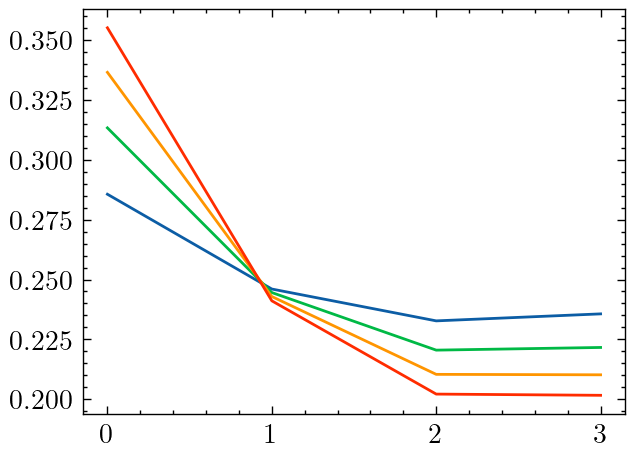

In [12]:
for i, key in enumerate(res_dict.keys()):
    plt.plot([0,1,2,3], res_dict[key]['grouped_tabl']['qx']/df['Vdot'][i])

In [6]:
res_dict[1010]['grouped_tabl']

,index,qx
0,0,358.655085
1,1,243.513730
2,2,204.171587
3,3,203.659598


In [9]:
358/1010

0.35445544554455444

In [ ]:
plt.plot(res_dict[1010]['grouped_tabl'])

In [ ]:
plt.plot(res_dict[277]['tabl'].index, res_dict[277]['tabl']['Pin'])

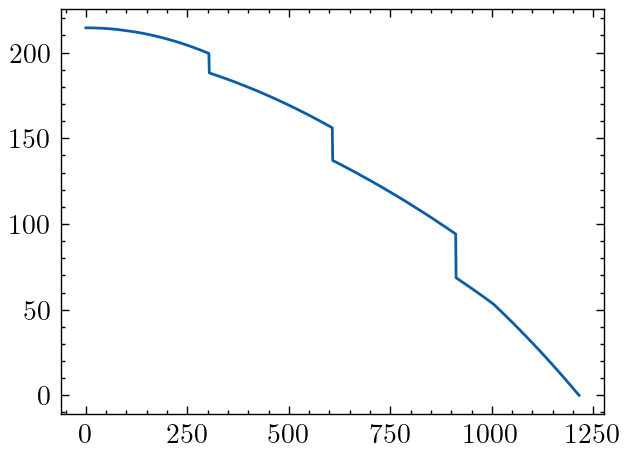

In [8]:
plt.plot(res_dict[1010]['tabl'].index, res_dict[1010]['tabl']['Pout'])

In [ ]:
plt.plot(res_dict[277]['df_PL'].index, res_dict[277]['df_PL']['uin'])

In [ ]:
67/277

In [ ]:
df['PL_hx_model'] = np.array(PL_res)/1000
df['PL_tot_model'] = df['PL_hx_model'] + df['both_singular']

df['ratio'] = df['PL_tot_model'] / df['PL']

In [ ]:
df

In [ ]:
# Assuming rconfig.wcol_in and rconfig.hfig are defined correctly in your setup
fig, ax1 = plt.subplots(figsize=(rconfig.wcol_in, rconfig.hfig(0.3, unit="in")))

ax1.plot(df['Vdot'], df['PL'], label='Exp',
                                            color=colors[0],
                                            linestyle=linestyles[0],
                                            marker=markers[0],
)

# Scatter plot with Model and Experimental data
ax1.plot(df['Vdot'], df['PL_tot_model'], label='Model',
                                                    color=colors[1],
                                                    linestyle=linestyles[1],
                                                    marker=markers[1],
)   

# Annotate each model data point with the ratio of PL / PL_tot_model
for i, (x, y, ratio) in enumerate(zip(df['Vdot'], df['PL_tot_model'], df['ratio'])):
    if i == 0:
        x_pos, y_pos = 20, -5
    elif i == len(df['Vdot']) - 1:
        x_pos, y_pos = 0, -15
    else:
        x_pos, y_pos = 20, -10
    ax1.annotate(rf"$\times$ {ratio:.2f}", (x, y), textcoords="offset points", xytext=(x_pos, y_pos), ha='center')

# Customizing grid and adding legend
ax1.grid(linewidth=0.5, color=rconfig.get_hex_code('grey', 70))
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.), ncol=2, frameon=False, handlelength=2.5)

ax1.set_xlabel('Vdot [L/h]')
ax1.set_ylabel('Pressure loss [kPa]')

# Show the plot
plt.show()


In [ ]:
plt.plot(tabl.index, tabl['qx']/(tabl['qx'].sum()/304))

In [ ]:
fig.savefig(r'G:\Mon Drive\GitHub\VDE_thesis\image\Chapter_PL\PL_V4.6_TUV_vs_1D.png', dpi=600)

In [ ]:
dp.write_pickle(r'G:\Drive partagés\Cercle Hard\R&D\Modèles numériques PVT\PVT-PL-model\Thesis\1D_CFD_TUV','V4.6_1D_simple', df)